<a href="https://colab.research.google.com/github/Rochakdh/100-days-of-ML/blob/master/Ultrasound_Image_Segmentation/Segmentation_in_Ultrasound_Images_(Fetal_Head_Detection).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segmentation in Ultrasound Images (Fetal Head Detection)

During pregnancy, ultrasound imaging is used to measure fetal biometrics. One of these measurements is the fetal head circumference (HC). The HC can be used to estimate the gestational age and monitor growth of the fetus. The HC is measured in a specific cross section of the fetal head, which is called the standard plane. 

![](https://grand-challenge-public-prod.s3.amazonaws.com/b/265/bannerV3_V5OH10E.x10.jpeg)

One of the methods that can be followed for measurement of fetal head circumference would be


1.   Identify fetal head in ultrasound image using image segmentation
2.   Fit the segmented fetal head using ellipse and measure circumference of the ellipse

In this notebook we aim to implement the first step of above methodology.



## Step 1: Semantic Segmentation of Fetal Head
We will be training a UNET model using dice loss as the loss function.

First lets understand what semantic segmentation means.

### Semantic Segmentation
The goal of semantic image segmentation is to label each pixel of an image with a corresponding class of what is being represented.
Note that the output itself is a high resolution image (typically of the same size as input image) in which each pixel is classified to a particular class. Thus it is a pixel level image classification.

![](https://miro.medium.com/max/700/1*nXlx7s4wQhVgVId8qkkMMA.png)

### UNET
U-net was originally invented and first used for biomedical image segmentation. Its architecture can be broadly thought of as an encoder network followed by a decoder network. Unlike classification where the end result of the the deep network is the only important thing, semantic segmentation not only requires discrimination at pixel level but also a mechanism to project the discriminative features learnt at different stages of the encoder onto the pixel space.



*   The encoder is the first half in the architecture diagram. It usually is a pre-trained classification network like VGG/ResNet where you apply convolution blocks followed by a maxpool downsampling to encode the input image into feature representations at multiple different levels.
*   The decoder is the second half of the architecture. The goal is to semantically project the discriminative features (lower resolution) learnt by the encoder onto the pixel space (higher resolution) to get a dense classification. The decoder consists of upsampling and concatenation followed by regular convolution operations.

You can learn more about UNET in this [paper](https://arxiv.org/abs/1505.04597v1).

![](https://developers.arcgis.com/assets/img/python-graphics/unet.png)

### Dice Coefficient
The Dice coefficient can be used to compare the pixel-wise agreement between a predicted segmentation and its corresponding ground truth. It is 2 times the area of overlap divided by the total number of pixels in both the images.

Dice Coefficient is calculated as below:

$$
\frac{2 * |X \cap Y|}{|X| + |Y|}
$$
where $X$ is the predicted set of pixels and $Y$ is the ground truth.

![](https://miro.medium.com/max/429/1*yUd5ckecHjWZf6hGrdlwzA.png)

**Dice Loss = 1 - Dice Coefficient**

### MONAI (Medical Open Network for AI)
MONAI is a freely available, community-supported, PyTorch-based framework for deep learning in healthcare imaging. It provides domain-optimized foundational capabilities for developing healthcare imaging training workflows in a native PyTorch paradigm.

You can learn more about MONAI project from [here](https://github.com/Project-MONAI/MONAI).


A example tutorial for 2d image segmentation can be found [here](https://github.com/Project-MONAI/tutorials/tree/master/2d_segmentation/torch).

Install MONAI library

In [19]:
!pip install monai

We will be using google drive to load data and save models.

In [20]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The dataset for today's lab is taken from [HC18](https://hc18.grand-challenge.org/) challenge. The [dataset](https://zenodo.org/record/1327317#.YcfdGJFBxNg) consists of training set, test set and csv files containing information about conversion of pixel to mm for each image and actual fetal head circumference (for training set only). The zip file for training set contains two types of images: 1) Ultrasound image exported in png format 2) Annotations to segmenta fetal head in png format.

In this lab, we will only be working on training set since the labels for test set are not available.

We will download [training_set.zip](https://zenodo.org/record/1327317/files/training_set.zip?download=1) file and extract the file in our google drive in the folder named `fetal_head_segmentation`.

Define path for root folder. 

The variable `ROOT` contains path to the folder where we will be extracting our training data to.

In [21]:
import os

In [22]:
ROOT = '/content/drive/My Drive/fetal_head_segmentation/'
TRAIN_PATH = os.path.join(ROOT, 'training_set')
ANNOTATION_PATH = os.path.join(ROOT, 'annotations')
ANNOTATION_DISC_PATH = os.path.join(ROOT, 'annotations_disc')

In [23]:
# If the folder for annotations do not exist, create new folders
if not os.path.exists(ANNOTATION_PATH):
    os.makedirs(ANNOTATION_PATH)

if not os.path.exists(ANNOTATION_DISC_PATH ):
    os.makedirs(ANNOTATION_DISC_PATH )

## You can run this segment only once.

In [24]:
!wget https://zenodo.org/record/1327317/files/training_set.zip?download=1

--2022-02-11 18:15:11--  https://zenodo.org/record/1327317/files/training_set.zip?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 132926838 (127M) [application/octet-stream]
Saving to: ‘training_set.zip?download=1.1’

training_set.zip?do 100%[===================>] 126.77M  2.26MB/s    in 37s     

2022-02-11 18:15:50 (3.39 MB/s) - ‘training_set.zip?download=1.1’ saved [132926838/132926838]



In [25]:
!unzip "/content/training_set.zip?download=1" -d "/content/drive/My Drive/fetal_head_segmentation"
from IPython.display import clear_output
clear_output()

To make out task easy, we are moving the annotation files into a different folder.


In [26]:
all_images = os.listdir(TRAIN_PATH)

for filename in all_images:
  if filename.endswith('Annotation.png'):
    target_path = os.path.join(ANNOTATION_PATH, filename)
    os.rename(os.path.join(TRAIN_PATH, filename), target_path)

We will now convert the ring shaped mask to disc shaped mask since it boosts the model performance.

In [27]:
import cv2
from matplotlib import pyplot as plt

In [56]:
def mask_generator(im):
  """
    Finds contours in the image to detect the ellipse and fill the ellipse by
    white color to get disc shaped masks.
  """
  imgray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
  ret,thresh = cv2.threshold(imgray,127,255,0)
  contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)    
  ellipse = cv2.fitEllipse(contours[0])
  return cv2.ellipse(im,ellipse,(255,255,255),-1)

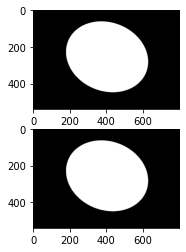

In [29]:
ring_images = os.listdir(ANNOTATION_PATH)


for image_name in ring_images:
  img = cv2.imread(os.path.join(ANNOTATION_PATH, image_name))
  disc_image = mask_generator(img)
  cv2.imwrite(os.path.join(ANNOTATION_DISC_PATH, image_name), disc_image)

fig, ax = plt.subplots(2, 1)
ax[0].imshow(img, cmap='gray')
ax[1].imshow(disc_image, cmap='gray')

# Training 

Import libraries

In [30]:
import logging
import numpy as np
import random
import sys
import tempfile
from glob import glob

import torch
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

In [31]:
import monai
from monai.data import ArrayDataset, create_test_image_2d, decollate_batch
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.transforms import (
    Activations,
    AddChannel,
    AsDiscrete,
    Compose,
    LoadImage,
    RandRotate90,
    RandSpatialCrop,
    ScaleIntensity,
    EnsureType,
    Resize,
    LabelToMask
)
from monai.visualize import plot_2d_or_3d_image

In [32]:
from monai.data.image_reader import PILReader
import cv2
import matplotlib.pyplot as plt
from monai.utils import set_determinism

We will be using GPU to accelerate training of model and set seed of random function for reproducibility.

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_determinism(seed=0)

In [34]:
monai.config.print_config()
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

MONAI version: 0.8.0
Numpy version: 1.19.5
Pytorch version: 1.10.0+cu111
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 714d00dffe6653e21260160666c4c201ab66511b

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.0.2
scikit-image version: 0.18.3
Pillow version: 7.1.2
Tensorboard version: 2.7.0
gdown version: 4.2.1
TorchVision version: 0.11.1+cu111
tqdm version: 4.62.3
lmdb version: 0.99
psutil version: 5.4.8
pandas version: 1.3.5
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



Defining data paths and transformations.

In [35]:
images = sorted(glob(TRAIN_PATH + '/*HC.png'))
annotations = sorted(glob(ANNOTATION_DISC_PATH + '/*_Annotation.png'))

# define transforms for images and annotations
train_imtrans = Compose(
    [
        LoadImage(PILReader(converter=lambda image: image.convert("L")), image_only=True), # convert image to grayscale
        AddChannel(),
        ScaleIntensity(),
        Resize((224, 224)),
        RandRotate90(prob=0.5, spatial_axes=(0, 1)),
        EnsureType(),
    ]
)
train_segtrans = Compose(
    [
        LoadImage(PILReader(converter=lambda image: image.convert("L")), image_only=True), # convert image to grayscale
        AddChannel(),
        ScaleIntensity(),
        Resize((224, 224)),
        RandRotate90(prob=0.5, spatial_axes=(0, 1)),
        EnsureType(),
    ]
)

val_imtrans = Compose(
    [
     LoadImage(PILReader(converter=lambda image: image.convert("L")), image_only=True), # convert image to grayscale
     AddChannel(),
     ScaleIntensity(),
     Resize((224, 224)),
     EnsureType()
    ]
)
val_segtrans = Compose(
    [
     LoadImage(PILReader(converter=lambda image: image.convert("L")), image_only=True), # convert image to grayscale
     AddChannel(),
     ScaleIntensity(),
     Resize((224, 224)),
     EnsureType()
     ]
)

post_trans = Compose([EnsureType(), Activations(sigmoid=True), AsDiscrete(threshold_values=True)])


/usr/local/lib/python3.7/dist-packages/monai/transforms/post/array.py:182: UserWarning: `threshold_values=True/False` is deprecated, please use `threshold=value` instead.
  warnings.warn("`threshold_values=True/False` is deprecated, please use `threshold=value` instead.")


Create a dataloader and test it.

torch.Size([10, 1, 224, 224]) torch.Size([10, 1, 224, 224])


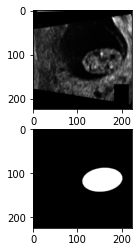

In [36]:
# define array dataset, data loader
check_ds = ArrayDataset(images, train_imtrans, annotations, train_segtrans)
check_loader = DataLoader(check_ds, batch_size=10, num_workers=2, pin_memory=torch.cuda.is_available())
im, seg = monai.utils.misc.first(check_loader)

print(im.shape, seg.shape)
fig, ax = plt.subplots(2, 1)
ax[0].imshow(im[0].squeeze().cpu().detach().numpy(), cmap='gray')
ax[1].imshow(seg[0].squeeze().cpu().detach().numpy(), cmap='gray')

Split training data into train and val set.

In [37]:
from sklearn.model_selection import train_test_split

images_train, images_val, annotations_train, annotations_val = train_test_split(images, annotations, test_size=0.10, random_state=42)
len(images_train), len(images_val), len(annotations_train), len(annotations_val)

(899, 100, 899, 100)

In [38]:
# create a training data loader
train_ds = ArrayDataset(images_train, train_imtrans, annotations_train, train_segtrans)
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=8, pin_memory=torch.cuda.is_available())
    
# create a validation data loader
val_ds = ArrayDataset(images_val, val_imtrans, annotations_val, val_segtrans)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4, pin_memory=torch.cuda.is_available())

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Define models, metrics, losses and optimizers

In [39]:
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)

# create UNet, DiceLoss and Adam optimizer
model = monai.networks.nets.UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)
loss_function = monai.losses.DiceLoss(sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-3)

Train

In [40]:
# start a typical PyTorch training
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
val_loss_values = list()
metric_values = list()
writer = SummaryWriter(ROOT)

num_epochs = 15
for epoch in range(num_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{num_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
                
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_ds) // train_loader.batch_size
        print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
    torch.save(model, os.path.join(ROOT, f"monai_segmentation_{epoch}.h5"))

    model.eval()
    with torch.no_grad():
        val_images = None
        val_labels = None
        val_outputs = None
        for val_data in val_loader:
            val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
            roi_size = (224, 224)
            sw_batch_size = 4
            val_outputs = sliding_window_inference(val_images, roi_size, sw_batch_size, model)
            val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
            # compute metric for current iteration
            dice_metric(y_pred=val_outputs, y=val_labels.int())

        # aggregate the final mean dice result
        metric = dice_metric.aggregate().item()

        # reset the status for next validation round
        dice_metric.reset()
        metric_values.append(metric)
        if metric > best_metric:
            best_metric = metric
            best_metric_epoch = epoch + 1
        print(
            "current epoch: {} current mean dice: {:.4f} best mean dice: {:.4f} at epoch {}".format(
                epoch + 1, metric, best_metric, best_metric_epoch
            )
        )
        writer.add_scalar("val_mean_dice (validation score)", metric, epoch + 1)
        
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")
writer.close()

----------
epoch 1/15


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


1/224, train_loss: 0.6429
2/224, train_loss: 0.5297
3/224, train_loss: 0.5531
4/224, train_loss: 0.5809
5/224, train_loss: 0.6017
6/224, train_loss: 0.5886
7/224, train_loss: 0.4625
8/224, train_loss: 0.5449
9/224, train_loss: 0.6129
10/224, train_loss: 0.5671
11/224, train_loss: 0.5652
12/224, train_loss: 0.5240
13/224, train_loss: 0.6578
14/224, train_loss: 0.6875
15/224, train_loss: 0.4952
16/224, train_loss: 0.4843
17/224, train_loss: 0.5826
18/224, train_loss: 0.4905
19/224, train_loss: 0.5314
20/224, train_loss: 0.4257
21/224, train_loss: 0.4428
22/224, train_loss: 0.5095
23/224, train_loss: 0.4855
24/224, train_loss: 0.5060
25/224, train_loss: 0.5447
26/224, train_loss: 0.4170
27/224, train_loss: 0.4777
28/224, train_loss: 0.4025
29/224, train_loss: 0.5141
30/224, train_loss: 0.4688
31/224, train_loss: 0.4652
32/224, train_loss: 0.4577
33/224, train_loss: 0.4693
34/224, train_loss: 0.5010
35/224, train_loss: 0.3993
36/224, train_loss: 0.4673
37/224, train_loss: 0.3761
38/224, tr

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


current epoch: 1 current mean dice: 0.8877 best mean dice: 0.8877 at epoch 1
----------
epoch 2/15
1/224, train_loss: 0.2012
2/224, train_loss: 0.2496
3/224, train_loss: 0.1961
4/224, train_loss: 0.2678
5/224, train_loss: 0.2490
6/224, train_loss: 0.2222
7/224, train_loss: 0.4276
8/224, train_loss: 0.3161
9/224, train_loss: 0.2720
10/224, train_loss: 0.3384
11/224, train_loss: 0.3092
12/224, train_loss: 0.2202
13/224, train_loss: 0.1724
14/224, train_loss: 0.1767
15/224, train_loss: 0.2551
16/224, train_loss: 0.2499
17/224, train_loss: 0.2891
18/224, train_loss: 0.3147
19/224, train_loss: 0.2667
20/224, train_loss: 0.2219
21/224, train_loss: 0.2924
22/224, train_loss: 0.2557
23/224, train_loss: 0.3660
24/224, train_loss: 0.3318
25/224, train_loss: 0.1909
26/224, train_loss: 0.3969
27/224, train_loss: 0.3214
28/224, train_loss: 0.2615
29/224, train_loss: 0.2037
30/224, train_loss: 0.1646
31/224, train_loss: 0.4164
32/224, train_loss: 0.2040
33/224, train_loss: 0.3130
34/224, train_loss:

Now let's plot the training loss (train set) and mean dice coefficient (val set).


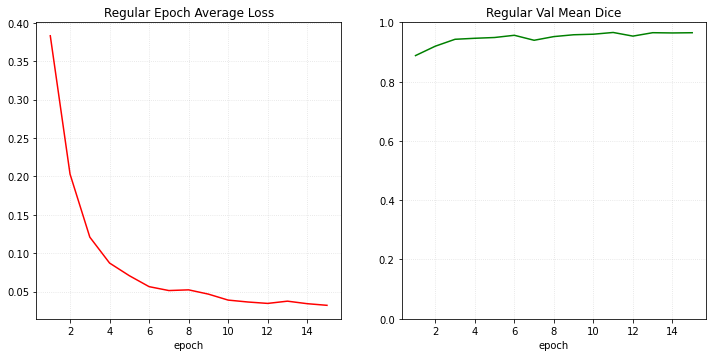

In [47]:
plt.figure("train", (12, 12))
plt.subplot(2, 2, 1)
plt.title("Regular Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.grid(alpha=0.4, linestyle=":")
plt.plot(x, y, color="red")

plt.subplot(2, 2, 2)
plt.title("Regular Val Mean Dice")
x = [i + 1 for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.ylim(0, 1)
plt.grid(alpha=0.4, linestyle=":")
plt.plot(x, y, color="green")


Load the model with best metric on validation set. For example, if the model had best performance in the 14th epoch, load the model from that epoch.

In [42]:
# Load the model with best dice metric
model = torch.load(os.path.join(ROOT, "monai_segmentation_11.h5"))
model.eval()

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (adn): ADN(
            (N): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (adn): ADN(
            (N): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(
            (unit

Test on some images of Validation set

In [43]:
import torchvision.transforms as transforms
import torchvision

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


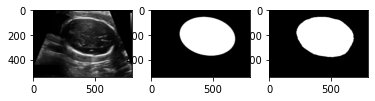

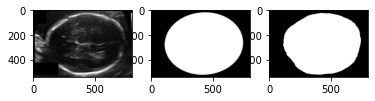

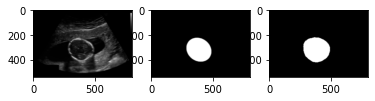

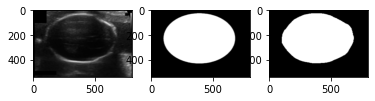

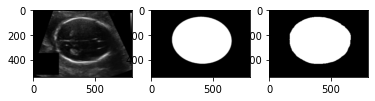

In [44]:
# Define transformation for post-processing
transform = transforms.Compose([transforms.ToPILImage(),transforms.RandomRotation([-90, -90]), transforms.Resize((540, 800)),transforms.ToTensor()])

with torch.no_grad():
  i = 0
  images_to_plot = []
  results_to_plot = []
  labels_to_plot = []
  for val_data in val_loader:
    i = i + 1
  
    val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
    val_images = val_images.to(device)
    val_outputs = post_trans(model(val_images))

    images_to_plot.append(transform(val_images[0]))
    results_to_plot.append(transform(val_outputs[0]))
    labels_to_plot.append(transform(val_labels[0]))

    if i == 5:
      break

for i in range(5):
  fig, ax = plt.subplots(1, 3)
  ax[0].imshow(images_to_plot[i].squeeze().cpu().detach().numpy(), cmap='gray')
  ax[1].imshow(labels_to_plot[i].squeeze().cpu().detach().numpy(), cmap='gray')
  ax[2].imshow(results_to_plot[i].squeeze().cpu().detach().numpy(), cmap='gray')

# References


1.   https://hc18.grand-challenge.org/
2.   https://github.com/Project-MONAI/tutorials
3.   https://developers.arcgis.com/python/guide/how-unet-works/
4.   https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2
5.   https://github.com/Project-MONAI/MONAI

# Assignments

## A. Calculation of Fetal Head Circumference
Once you have trained the model to segment fetal head from an image, 

1.  Calculate the fetal head circumference for validation set.
2.  Calculate mean absolute error for measurement of fetal head circumference in validation set.
3.  Calculate mean dice coefficient for validation set.

**Hint**: You can use `cv2` in python to fit ellipse on the segmented fetal head and using the ellipse parameters calculate circumference of the ellipse. Don't forget to convert pixel values into mm using the [csv file](https://zenodo.org/record/1327317/files/training_set_pixel_size_and_HC.csv?download=1) available in the HC18 dataset.

## B. Plotting good and bad examples
Plot the examples that were hard for the network to segment and the examples where model could segment fetal head with least error.

**Hint**: You can select examples that exceed a certain threshold of dice score for good examples and examples with least dice scores for bad examples.


In [45]:
import pandas as pd


In [58]:
df=pd.read_csv("/content/drive/MyDrive/training_set_pixel_size_and_HC.csv")

In [59]:
image_name=[]
pixel_size=[]
circum=[]
for name in images_val:
  image_name.append(name.split("/")[-1])
  pixel_size.append(float(df[df.columns[1]][df.filename==image_name[-1].split("/")[-1]]))
  circum.append(float(df[df.columns[2]][df.filename==image_name[-1].split("/")[-1]]))


In [60]:
# Define transformation for post-processing
transform = transforms.Compose([transforms.ToPILImage(),transforms.RandomRotation([-90, -90]), transforms.Resize((540, 800)),transforms.ToTensor()])

with torch.no_grad():
  metrics=[]
  mae=[]
  for i,val_data in enumerate(val_loader):
  
    val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
    val_images = val_images.to(device)
    val_outputs = post_trans(model(val_images))
    metrics.append(dice_metric(y_pred=val_outputs, y=val_labels.int()).cpu().detach().numpy()[0][0])
    
    images_to_plot.append(transform(val_images[0]))
    results_to_plot.append(transform(val_outputs[0]))
    labels_to_plot.append(transform(val_labels[0]))

    contours, _ = cv2.findContours(results_to_plot[-1].squeeze().cpu().detach().numpy().astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours[0])<5:
      continue
    ellipse = cv2.fitEllipse(contours[0])
    a,b=ellipse[1]
    # print(3.141569*(a/2+b/2)*pixel_size[i],circum[i])
    mae.append(abs(3.141569*(a/2+b/2)*pixel_size[i]-circum[i]))

    

# for i in range(5):
#   fig, ax = plt.subplots(1, 3)
#   ax[0].imshow(images_to_plot[i].squeeze().cpu().detach().numpy(), cmap='gray')
#   ax[1].imshow(labels_to_plot[i].squeeze().cpu().detach().numpy(), cmap='gray')
#   ax[2].imshow(results_to_plot[i].squeeze().cpu().detach().numpy(), cmap='gray')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [61]:
args_desc=np.argsort(metrics)[::-1]
args_asc=args_desc[::-1]

In [62]:
metrics[args_asc[0]]

0.3264294

In [63]:
args_asc

array([60, 76, 95, 25, 53, 96, 71, 40, 12, 94,  2, 54, 15, 79, 44, 89, 84,
       19, 51, 67, 62, 56, 66, 80,  5, 14, 42, 16, 22, 73, 24,  6,  0, 68,
       49, 97, 88, 92,  7, 31, 43, 26, 98, 37, 81, 32, 61, 39, 87, 83, 45,
       48,  9, 75, 63, 21, 99, 36, 90, 13,  4, 18, 70, 41, 85, 58, 77, 33,
        8, 82, 35, 46, 27, 17, 93,  1, 69, 20, 52, 47, 65, 86, 59, 78, 23,
       74, 28, 57, 29, 91, 64, 38, 34, 55, 11, 10, 30, 50, 72,  3])

In [64]:
mean_dice_metric=sum(metrics)/len(metrics)
print(mean_dice_metric)

0.9533783832192421


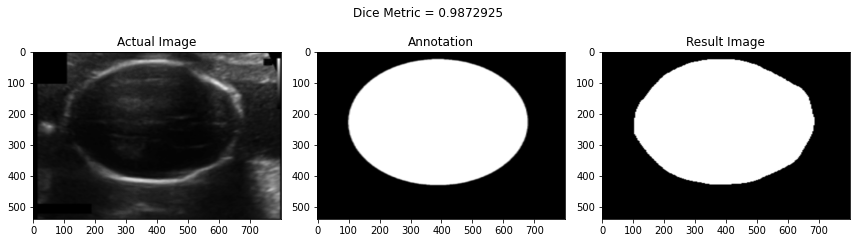

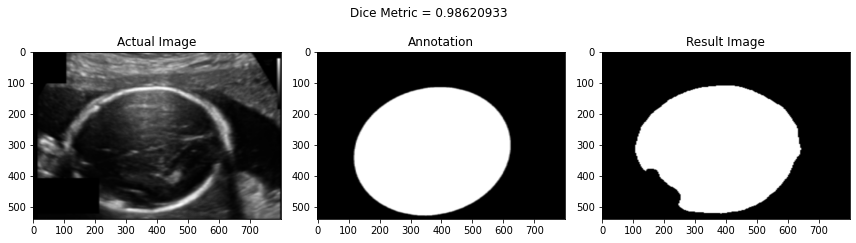

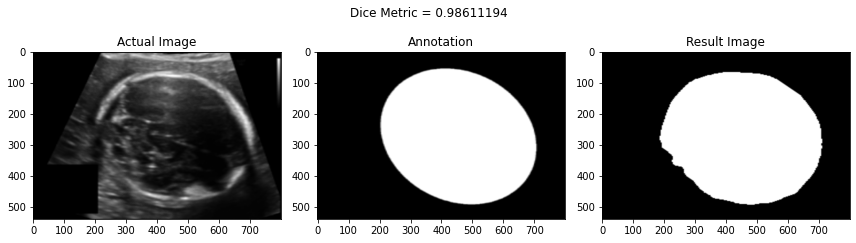

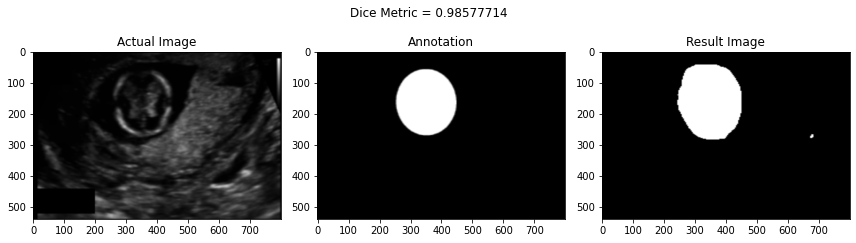

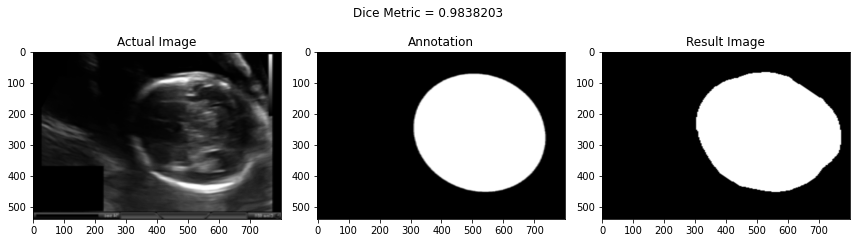

In [65]:
for i in range(5):
  fig, ax = plt.subplots(1, 3,figsize=(12,12))
  # fig.tight_layout()
  fig.suptitle("Dice Metric = "+str(metrics[args_desc[i]]))
  ax[0].imshow(images_to_plot[args_desc[i]].squeeze().cpu().detach().numpy(), cmap='gray')
  ax[0].set_title("Actual Image")
  ax[1].imshow(labels_to_plot[args_desc[i]].squeeze().cpu().detach().numpy(), cmap='gray')
  ax[1].set_title("Annotation")
  ax[2].imshow(results_to_plot[args_desc[i]].squeeze().cpu().detach().numpy(), cmap='gray')
  ax[2].set_title("Result Image")
  fig.tight_layout()
  fig.subplots_adjust(top=1.65)
    

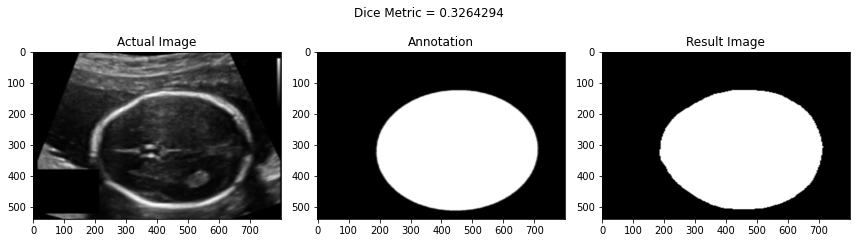

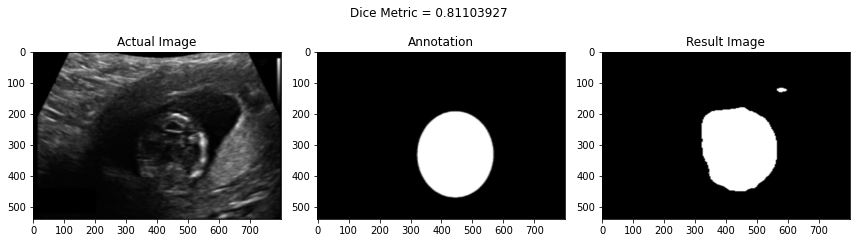

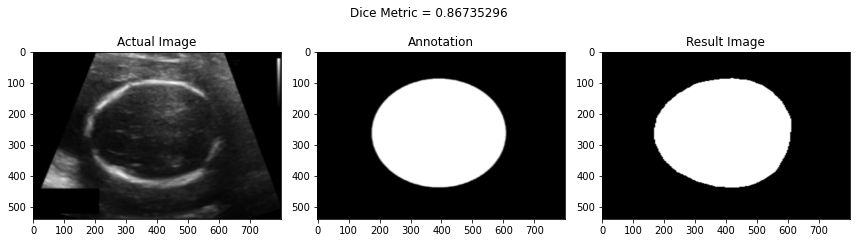

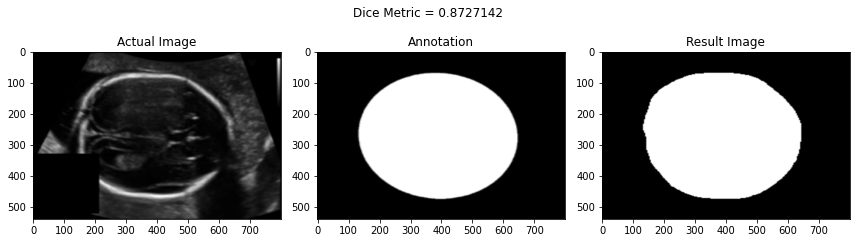

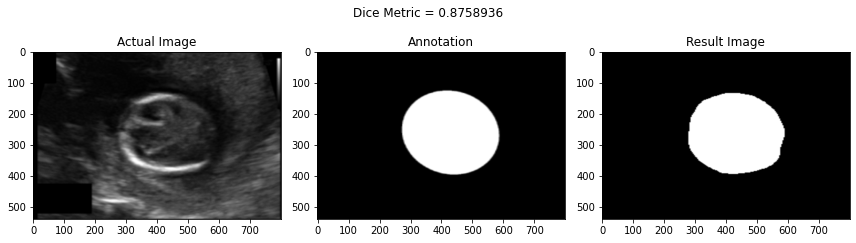

In [66]:
for i in range(5):
  fig, ax = plt.subplots(1, 3,figsize=(12,12))
  # fig.tight_layout()
  fig.suptitle("Dice Metric = "+str(metrics[args_asc[i]]))
  ax[0].imshow(images_to_plot[args_asc[i]].squeeze().cpu().detach().numpy(), cmap='gray')
  ax[0].set_title("Actual Image")
  ax[1].imshow(labels_to_plot[args_asc[i]].squeeze().cpu().detach().numpy(), cmap='gray')
  ax[1].set_title("Annotation")
  ax[2].imshow(results_to_plot[args_asc[i]].squeeze().cpu().detach().numpy(), cmap='gray')
  ax[2].set_title("Result Image")
  fig.tight_layout()
  fig.subplots_adjust(top=1.65)
    

In [67]:
MeanAbErr=sum(mae)/len(mae)
print(MeanAbErr)

8.641630868066345
